# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


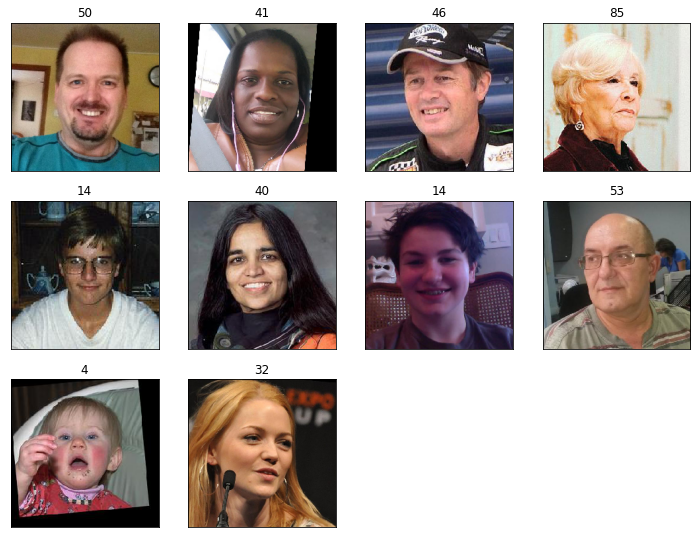

In [3]:
features, target = next(train_gen_flow)

# выводим 10 изображений
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
print(features.shape)

(32, 224, 224, 3)


In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


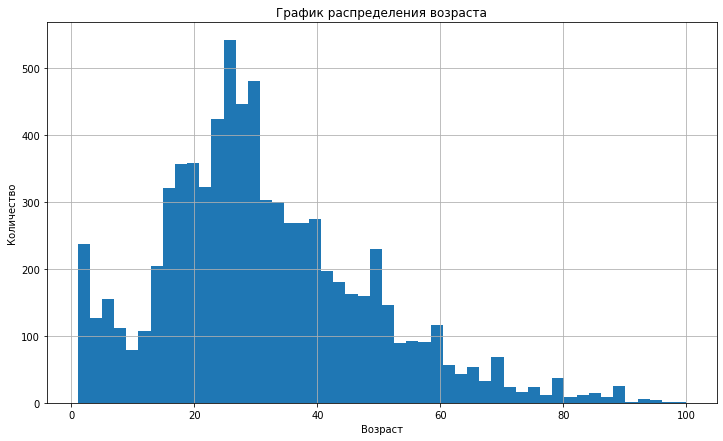

In [7]:
labels['real_age'].hist(figsize=(12,7), bins=50)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('График распределения возраста')
plt.grid(True)
plt.show()

**Выводы:**

* Выборка достаточного размера, поэтому аугментацию не используем
* Разрешение 224 на 224 и 3 канала цвета
* основная масса изображений имеет вертикальную ориентацию
* пик данных приходится на возраст примерно 25 лет
* основная масса фотографий людей в возрасте от 18 до 40
* предсказание модели будет успешнее на фотографиях, где возраст от 18 до 40 лет, так как данные по этой категории преобладают.
* присутствуют черно-белые изображения, а также изображения, смещенные относительно вертикальной оси.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >

def load_train(path):
    labels = pd.read_csv(path +'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path +'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path +'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimazer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimazer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        batch_size=batch_size,
        verbose=2, shuffle=True) 

    return model

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 178 steps, validate for 60 steps
Epoch 1/5
2022-06-01 12:10:14.516556: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] 
Successfully opened dynamic library libcublas.so.10
2022-06-01 12:10:15.175871: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] 
Successfully opened dynamic library libcudnn.so.7
178/178 - 124s - loss: 229.6672 - mae: 10.8677 - val_loss: 881.2457 - val_mae: 24.8288
Epoch 2/5
178/178 - 36s - loss: 59.9350 - mae: 5.9526 - val_loss: 839.6187 - val_mae: 24.0567
Epoch 3/5
178/178 - 36s - loss: 30.8455 - mae: 4.2808 - val_loss: 315.9050 - val_mae: 13.2023
Epoch 4/5
178/178 - 37s - loss: 19.5476 - mae: 3.3815 - val_loss: 135.5583 - val_mae: 8.6360
Epoch 5/5
178/178 - 36s - loss: 14.8232 - mae: 2.9627 - val_loss: 79.2732 - val_mae: 6.7052
WARNING:tensorflow:sample_weight modes were coerced from

## Анализ обученной модели

* Датасет содержит 7591 фотографию, разрешением 224 на 224 и 3 канала цвета.
* Аугментацию не используем, так как данных достаточно
* пик данных приходится на возраст примерно 25 лет
* основная масса фотографий людей в возрасте от 18 до 40
* Для решения задачи использовали предобученную на ImageNet сеть
* Адаптировали ResNet50 к данной задаче, убрав верхушку и сконструировав её заново
* Доля валидационной выборки - 0.25
* количество эпох - 5
* за авоматический подбор величины шага обучения сети отвечает алгоритм Adam со скоростью обучения 0.0001
* Функция потерь - средняя квадратическая ошибка (mse)
* Средняя абсолютная ошибка (MAE)  модели составляет 6.7052, что означает, что погрешность в предсказаниях в пределах 7 лет.
* Для основного потока клиентов в возрасте 18 - 40 лет погрешность модели большого значения не имеет, поэтому проанализировать покупки и предложить товары, которые могут заинтересовать покупателей этой возрастной группы с помощью этой модели можно.
* Но для контролироля добросовестности кассиров при продаже алкоголя данную модель рекомендовать нельзя - 7 лет слишком большая погрешность.

